In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [7]:
data_raw = np.loadtxt(open("../Datasets/mnist_train.csv", "rb"), delimiter=",")
test_data_raw = np.loadtxt(
    open("../Datasets/mnist_test.csv", "rb"), delimiter=","
)

In [8]:
# Function to make the dataset
def makeTheDataset(N, oversampling=False):

    # Extract N number of data form the full dataset
    data = data_raw[:N, 1:]
    labels = data_raw[:N, 0]
    test_data = test_data_raw[:, 1:]
    test_labels = test_data_raw[:, 0]
    # Data normalization
    dataNorm = data / np.max(data)

    # Convert to tensors
    dataT = torch.tensor(dataNorm).float()
    labelsT = torch.tensor(labels).long()
    test_dataT = torch.tensor(test_data).float()
    test_labelsT = torch.tensor(test_labels).long()

    # Use train/test split of the data
    train_data, dev_data, train_labels, dev_labels = train_test_split(
        dataT, labelsT, train_size=0.9
    )

    # Data oversampling
    if oversampling:
        train_data = torch.cat((train_data, train_data), axis=0)
        train_labels = torch.cat((train_labels, train_labels), axis=0)

    # Convert to pytorch dataset
    train_data = TensorDataset(train_data, train_labels)
    dev_data = TensorDataset(dev_data, dev_labels)
    test_data = TensorDataset(test_dataT, test_labelsT)

    # translate into dataloader objects
    batch_size = 16
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        generator=torch.Generator(device),
    )
    dev_loader = DataLoader(
        dev_data,
        batch_size=test_data.tensors[0].shape[0],
        generator=torch.Generator(device),
    )
    test_loader = DataLoader(
        test_data,
        batch_size=test_data.tensors[0].shape[0],
        generator=torch.Generator(device),
    )

    return train_loader, dev_loader, test_loader

In [9]:
# Check the sizes
r, d, t = makeTheDataset(50000, False)
print(r.dataset.tensors[0].shape)
print(d.dataset.tensors[0].shape)
print(t.dataset.tensors[0].shape)

r, d, t = makeTheDataset(50000, True)
print(r.dataset.tensors[0].shape)
print(d.dataset.tensors[0].shape)
print(t.dataset.tensors[0].shape)

torch.Size([45000, 784])
torch.Size([5000, 784])
torch.Size([10000, 784])
torch.Size([90000, 784])
torch.Size([5000, 784])
torch.Size([10000, 784])


In [5]:
# Create the model function
def createNewMNISTNet(lr=0.001):
    # Model class
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(784, 64)

            # Hidden Layers
            self.hidden1 = nn.Linear(64, 32)
            self.hidden2 = nn.Linear(32, 32)

            # Output Layer
            self.output = nn.Linear(32, 10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            return self.output(x)

    # Model Instance
    net = mnistNet()
    # Loss Function
    lossFun = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, lossFun, optimizer

In [ ]:
# Function to train the model
nEpochs = 100


def trainTheModel():
    # The best model dictionary
    theBestModel = {"Accuracy": 0, "net": None}
    net, lossFun, optimizer = createNewMNISTNet(lr=0.001)

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    devAcc = []

    # The Loop
    for epoch in range(nEpochs):
        # Train Mode
        net.train()
        # Loop over batches
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss
            batchLoss.append(loss.cpu().item())

            # Compute Batch Accuracy
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
            )

        # End of batch Loop
        # Average Loss
        losses[epoch] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # Dev Accuracy
        net.eval()
        X, y = next(iter(dev_loader))
        with torch.no_grad():
            yHat = net(X)

        devAcc.append(
            100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
        )

        # New! Store this model if it's the best so far
        if devAcc[-1] > theBestModel["Accuracy"]:

            # new best accuracy
            theBestModel["Accuracy"] = devAcc[-1].item()

            # model's internal state
            theBestModel["net"] = copy.deepcopy(net.state_dict())

    # End of epoch

    return trainAcc, devAcc, losses, net, theBestModel

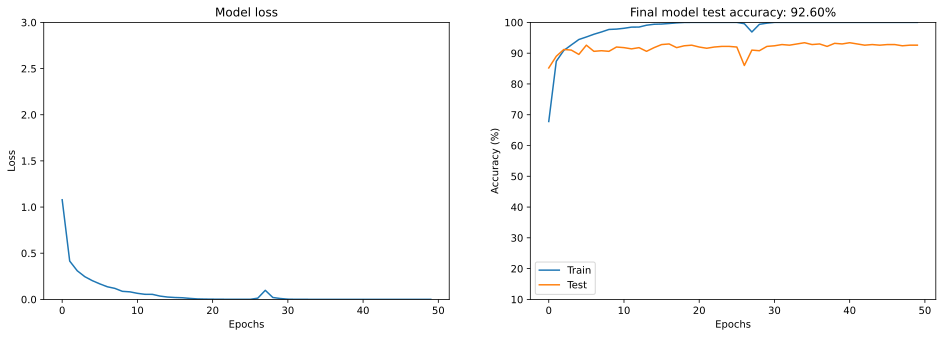

In [8]:
# generate a dataset
train_loader, test_loader = makeTheDataset(5000)

# test it
trainAcc, testAcc, losses, net = trainTheModel()


# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses.cpu())
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {testAcc[-1]:.2f}%")
ax[1].legend()

plt.show()

In [ ]:
# Save the model
torch.save(net.state_dict(), "trainedModelstate.pt")

In [11]:
# New model instances
newModel1 = createNewMNISTNet(lr=0.001)[0]
newModel2 = createNewMNISTNet(lr=0.001)[0]

# Load the model
newModel1.load_state_dict(torch.load("trainedModelstate.pt", weights_only=False))

<All keys matched successfully>

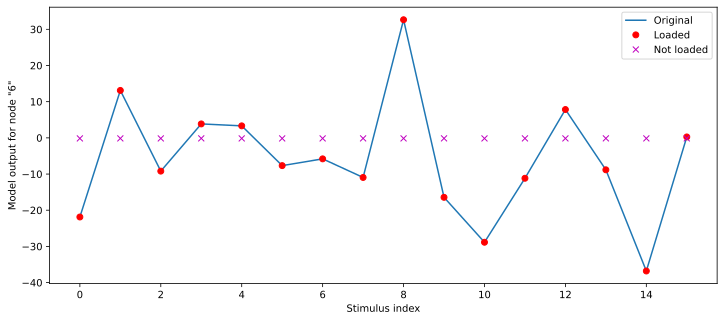

In [ ]:
# get some data from the test loader
X, y = next(iter(train_loader))

yHatNet = net(X)
yHatModel1 = newModel1(X)
yHatModel2 = newModel2(X)

# show that the results overlap
fig = plt.figure(figsize=(12, 5))
plt.plot(yHatNet[:, 5].cpu().detach(), label="Original")
plt.plot(yHatModel1[:, 5].cpu().detach(), "ro", label="Loaded")
plt.plot(yHatModel2[:, 5].cpu().detach(), "mx", label="Not loaded")
plt.legend()
plt.xlabel("Stimulus index")
plt.ylabel('Model output for node "6"')

plt.show()